In this project, we will perform a multi-class classification of medical images of different body parts using 2 deep learning models. First, we will use the **dense neural networks or  multi layer perceptron (MLP) model with tensorflow** and analyse how accurately it can classify the images. Later, we will use  a simplified **Convolutional Neural Networks (CNN) model with tensorflow** to see if that improves the classification metrics. This dataset has been collected from [Kaggle](https://www.kaggle.com/datasets/andrewmvd/medical-mnist/data).

In order to do that, let's import all the relevant libraries, i.e, numpy and pandas first.

In [1]:
import numpy as np
import pandas as pd

## Exploratory data analysis and visualization.
Now we need to load the data and do little bit of investigation. This dataset has 5 categories of medical data corresponding to different body parts. 
1. Hand 
2. Breast
3. Head 
4. Abdomen
5. Chest
   
We will load the images and get a glimpse of some of these images:

In [2]:
import glob
data_path = '../../data/med_dataset/*'  #dataset path

data_dirpaths = []
for dir in glob.glob(data_path):
    data_dirpaths.append(dir) #appending each category dataset path
print(data_dirpaths)

['../../data/med_dataset/Hand', '../../data/med_dataset/BreastMRI', '../../data/med_dataset/HeadCT', '../../data/med_dataset/AbdomenCT', '../../data/med_dataset/CXR']


So there are 5 directories containing the images for each category. Now let's go to each cateogory and collect their filenames and category and write into a pandas dataframe

In [3]:
import os
image_files = [] # list to store image file paths
category = [] # List to store image categories
cat_name = ['hand', 'breast', 'head', 'abdomen', 'chest']
for i, data_dirpath in enumerate(data_dirpaths):
    data_dirpath += '/*.jpeg'
    print(data_dirpath)
    image_files_cat = sorted(glob.glob(data_dirpath))
    cat_len = len(image_files_cat)
    image_files += image_files_cat
    category += [cat_name[i]]*cat_len

print(f"Number of image files: {len(image_files)}")    
print(f" Length of category items : {len(category)}")

# Write everything to a pandas dicitonary
dict = {'image_file_paths' : image_files, 'category': category}
df = pd.DataFrame(dict)

../../data/med_dataset/Hand/*.jpeg
../../data/med_dataset/BreastMRI/*.jpeg
../../data/med_dataset/HeadCT/*.jpeg
../../data/med_dataset/AbdomenCT/*.jpeg
../../data/med_dataset/CXR/*.jpeg
Number of image files: 48954
 Length of category items : 48954


In [4]:
df.head()

,image_file_paths,category
0,../../data/med_dataset/Hand/000000.jpeg,hand
1,../../data/med_dataset/Hand/000001.jpeg,hand
2,../../data/med_dataset/Hand/000002.jpeg,hand
3,../../data/med_dataset/Hand/000003.jpeg,hand
4,../../data/med_dataset/Hand/000004.jpeg,hand


In [5]:
df.describe()

,image_file_paths,category
count,48954,48954
unique,48954,5
top,../../data/med_dataset/Hand/000000.jpeg,hand
freq,1,10000


In [6]:
df['category'].value_counts()

category
hand       10000
head       10000
abdomen    10000
chest      10000
breast      8954
Name: count, dtype: int64

As we can see there are 10000 images in each category except the breast category which has 8954 images in it. So this is a well balanced dataset to conduct the classification task.

Let's try to read some of the images and visualize them using the matplotlib library.

(64, 64)


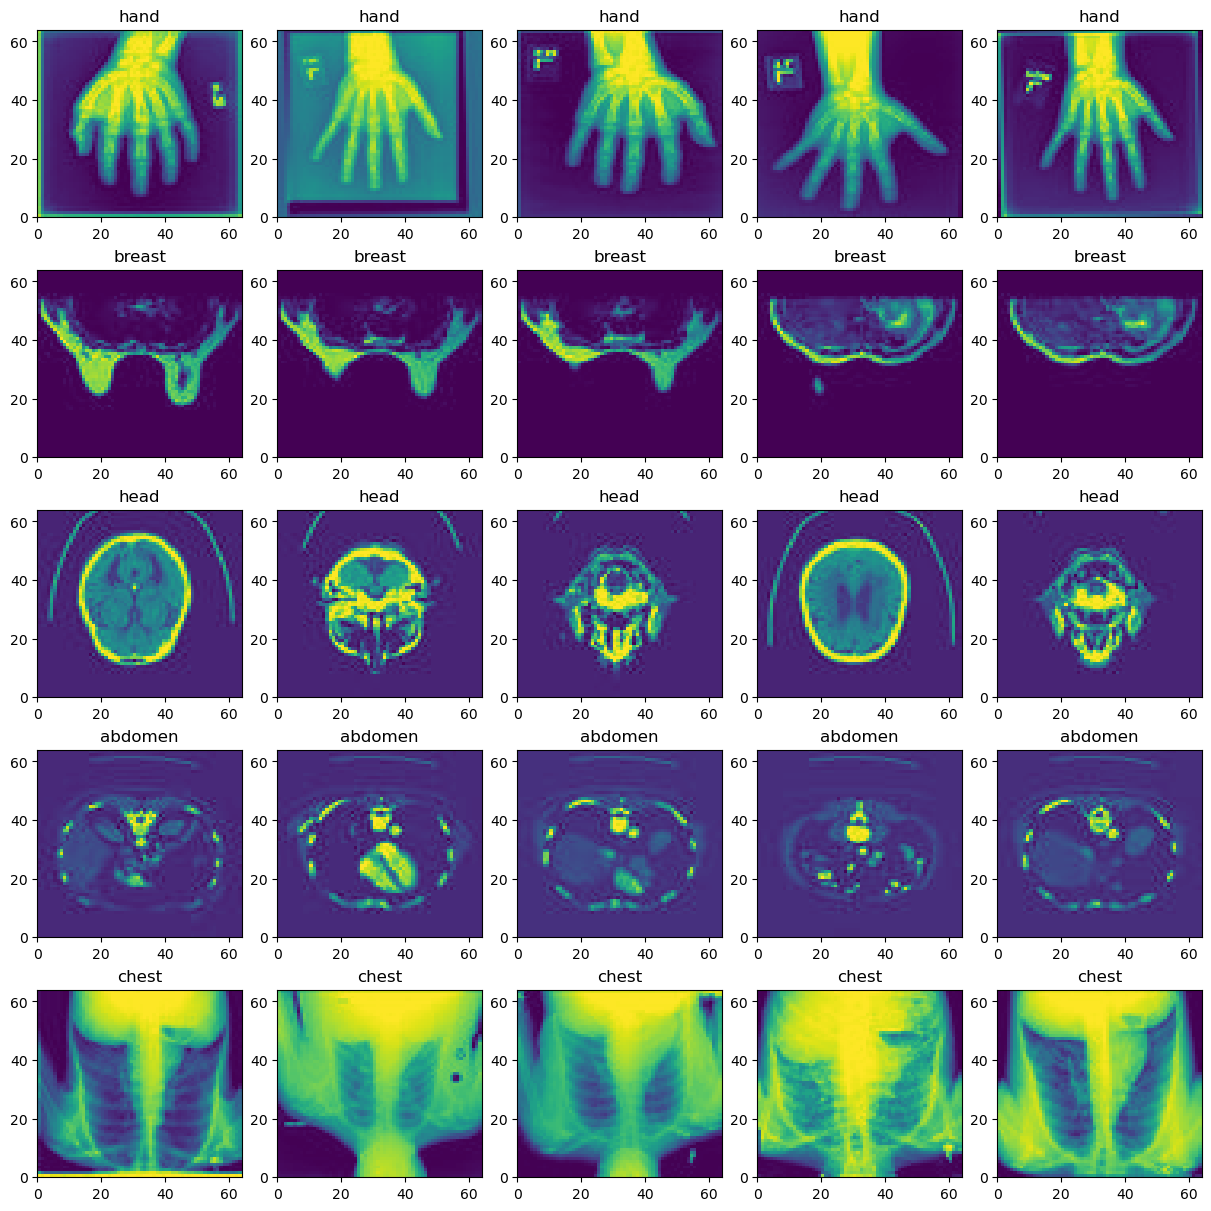

In [7]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5,5, constrained_layout=True, figsize = (12,12))
for i in range(5):
    cat = cat_name[i]
    read_files = list(df[df['category'] == cat]['image_file_paths'][:5])
    for j in range(5):
        img = mpimg.imread(read_files[j])
        #print(img.shape)
        axs[i,j].pcolormesh(img)
        axs[i,j].set_title(cat)
print(img.shape)
plt.show()

## Train, validation and test splitting
The plot shows the different categories of medical images. Each image is 60 by 60 pixel == 3600 features when the 2D array is flattened.

The hand, abdomen, chest and breast has more or less same features while the head images vary a lot. Before modelling the data, we need to shuffle the data and split it into train, validation and test set. 

In [8]:
#shuffling and returning all the data
df_new = df.sample(frac = 1)

#Let's convert the categorical values into numerical values
df_new['category'].replace(cat_name, [0, 1, 2, 3, 4], inplace=True)
df_new.head()

,image_file_paths,category
46205,../../data/med_dataset/CXR/007251.jpeg,4
42520,../../data/med_dataset/CXR/003566.jpeg,4
2376,../../data/med_dataset/Hand/002376.jpeg,0
39999,../../data/med_dataset/CXR/001045.jpeg,4
11097,../../data/med_dataset/BreastMRI/001097.jpeg,1


In [9]:
from sklearn.model_selection import train_test_split

# Split into train and test first
data_train, data_test = train_test_split(df_new, test_size = 0.2, random_state = 0)

# Split the test into test and validate again
data_val, data_test = train_test_split(data_test, test_size = 0.5, random_state = 0)
print(f" Train data shape : {data_train.shape}, Test data shape : {data_test.shape}, Validation data shape: {data_val.shape}")

 Train data shape : (39163, 2), Test data shape : (4896, 2), Validation data shape: (4895, 2)


Now before modelling, we need to load the data from all the image into a numpy array

In [10]:
X_train = np.zeros((data_train.shape[0], 64, 64))
y_train = np.array(data_train['category']).reshape(-1, 1)

print(y_train.shape)

X_val = np.zeros((data_val.shape[0], 64, 64))
y_val = np.array(data_val['category']).reshape(-1, 1)

X_test = np.zeros((data_test.shape[0], 64, 64))
y_test = np.array(data_test['category']).reshape(-1, 1)

(39163, 1)


In [11]:
#Now let's read the images and fill in the training dataset:
# training data
print("Starting to collect data from images")
for i,filepath_train in enumerate(list(data_train['image_file_paths'])):
    img_array = mpimg.imread(filepath_train)
    X_train[i,:,:] = img_array

# validation data
for j,filepath_val in enumerate(list(data_val['image_file_paths'])):
    img_array = mpimg.imread(filepath_val)
    X_val[j,:,:] = img_array

# testing data
for k,filepath_test in enumerate(list(data_test['image_file_paths'])):
    img_array = mpimg.imread(filepath_test)
    X_test[k,:,:] = img_array
print("Finished collecting images")

Starting to collect data from images
Finished collecting images


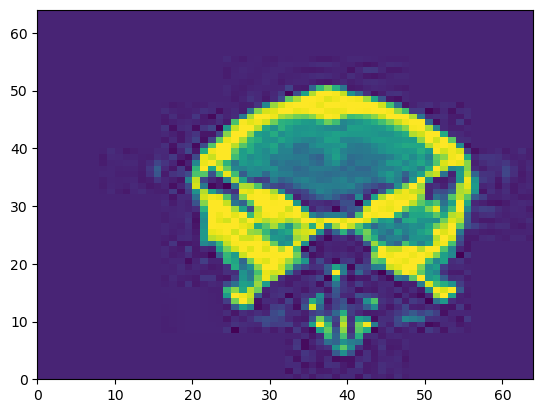

In [12]:
#plotting a random image to test it
plt.pcolormesh(X_train[100,:,:])
plt.show()

## Model building with Tensorflow
### Dense Neural Network or Multi Layer Perceptron
Now let's build a Multi Layer Perceptron model with tensorflow.
The input layer will flatten the array values giving 4096 features. Let's build 2 hidden layers, first with 25 units and second with 15 units, and at the end we will have an output layer with 5 units. We will keep the relu activation units for the hidden layers. In principal we could use softmax regression unit for the output layers. In tensorflow it is better recommended to keep the output layers linear and calculate probabilities of each class later in order to avoid round off errors.

We will also use Flatten layer to flatten the array into a one dimensional array. Using Sequential function, we can connect multiple Dense layers as a deep neural network. Depending the performance of this model, we can build complex models later on.


In [13]:
import random
# load the tensorflow libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Let's build the model

tf.random.set_seed(42) # Set the random seed to get same reproducable results
#np.random.seed(4)
#random.seed(4)

model1 = Sequential([
        Flatten(input_shape=[64, 64]), 
        Dense(25, activation="relu", name = 'layer1'),
        Dense(15, activation="relu", name = 'layer2'),
        Dense(5, activation="linear", name = 'layer3')
])

2024-08-19 00:27:47.837802: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


The first hidden layer will have ((4096 weights)+ 1 bias term) * 25 neural units = 102425 parameters

The second hidden layer will have ((25 weights) + 1 bias term) * 15 neural units = 390 parameters

layer 3 will have ((15 weights) + 1 bias term) * 5 neural units = 80 parameters

Total trainable parameters = 102895 

Let's look at the model summary:

In [14]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 layer1 (Dense)              (None, 25)                102425    
                                                                 
 layer2 (Dense)              (None, 15)                390       
                                                                 
 layer3 (Dense)              (None, 5)                 80        
                                                                 
Total params: 102,895
Trainable params: 102,895
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Get layer information
model1.layers

In [16]:
# Get each layers
[layer1, layer2, layer3, layer4] = model1.layers

# Get each layer parameters
w1, b1 = layer2.get_weights()
print(w1.shape, b1.shape)

#printing randomly initialized parameters of the first unit
print(w1[:10, 0])

(4096, 25) (25,)
[-0.0160534  -0.02433901 -0.01601636 -0.03750589  0.0078755   0.01080968
 -0.03459178 -0.01576263 -0.00119375  0.00284962]


## Model compiling and training
Since we set the activation function of the output layers to be linear, we need to do logits = True while compiling the model. Also we will use the 
sparse_categorical_crossentropy loss function and Adam optimizer for choosing the learning rate for optimizing the cost function. Adam optimizer can adjust the the learning rate of each model parameter adaptively depending on how the cost function changes.

In [17]:
model1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
               metrics = ["accuracy"])

In [18]:
history1 = model1.fit(X_train, y_train, epochs = 30, validation_data=(X_val, y_val))

Epoch 1/30
1224/1224 [==============================] - 2s 1ms/step - loss: 2.1078 - accuracy: 0.9475 - val_loss: 0.6210 - val_accuracy: 0.9814
Epoch 2/30
1224/1224 [==============================] - 1s 1ms/step - loss: 0.6991 - accuracy: 0.9693 - val_loss: 0.4468 - val_accuracy: 0.9636
Epoch 3/30
1224/1224 [==============================] - 1s 1ms/step - loss: 0.4378 - accuracy: 0.9708 - val_loss: 0.7411 - val_accuracy: 0.9636
Epoch 4/30
1224/1224 [==============================] - 1s 1ms/step - loss: 0.2713 - accuracy: 0.9761 - val_loss: 0.4271 - val_accuracy: 0.9620
Epoch 5/30
1224/1224 [==============================] - 1s 1ms/step - loss: 0.4625 - accuracy: 0.9660 - val_loss: 0.1642 - val_accuracy: 0.9751
Epoch 6/30
1224/1224 [==============================] - 1s 1ms/step - loss: 0.2869 - accuracy: 0.9736 - val_loss: 0.2065 - val_accuracy: 0.9783
Epoch 7/30
1224/1224 [==============================] - 1s 1ms/step - loss: 0.3025 - accuracy: 0.9723 - val_loss: 0.2102 - val_accuracy:

At a time the model is trained in batches of 32 images and each time the model goes through 1224 batches per epoch to train the data. As we can see we are seeing a 99 % accuracy in the training and validation dataset which is great.

Let's look at the predictions now.

(30, 2)


/var/folders/c8/g5hp4hlx7dv6gv7n9zdg74rc0000gn/T/ipykernel_14087/1848071422.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/var/folders/c8/g5hp4hlx7dv6gv7n9zdg74rc0000gn/T/ipykernel_14087/1848071422.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

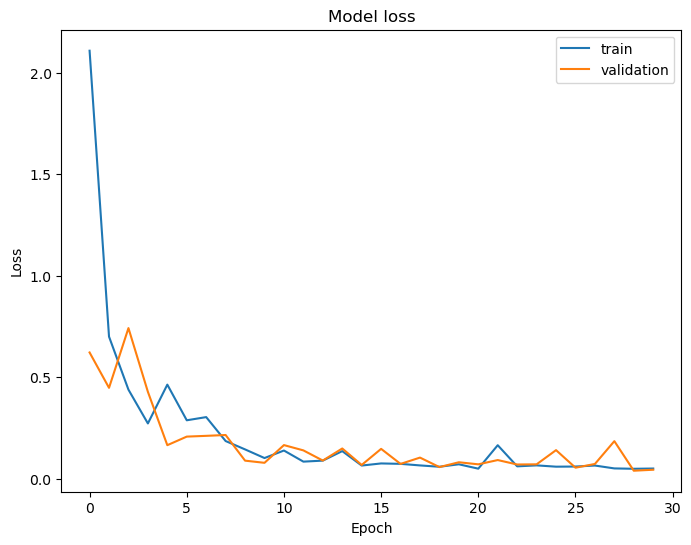

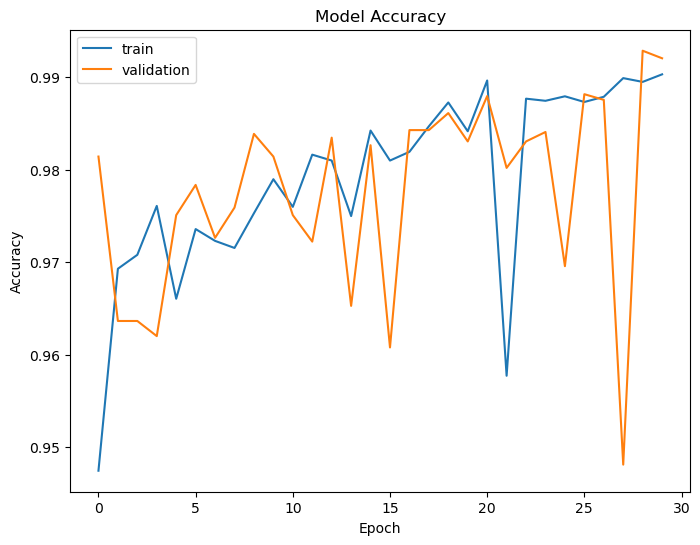

In [19]:
# Now let's plot the model loss and accuracy for both the training and validataion set as a function 
# of number of epochs.

# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history1.history)

# losses data frame
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)

print(df_loss.shape)

# accuracy data frame
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)

# plotting the loss and accuracy
df_loss.plot(title='Model loss',figsize=(8,6)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(8,6)).set(xlabel='Epoch',ylabel='Accuracy')

The loss of both training and validation datasets are decreasing as expected. There is a dip in the accuracy plot in the beginning probably because the gradient descent not converging in the right direction giving rise to high losses at the same time. The accuracy of the training and validation dataset is reaching 99% which is really good metrics. Let's take a look at the other statistics as well.

In [20]:
# Calculating the predictions for the training dataset
#Get the linear value from the mode
logits_train = model1.predict(X_train)
pred_train = tf.nn.softmax(logits_train) # this basically gives the probability of each class
ypred_train = np.argmax(pred_train, axis = 1)
#print(y_pred_train.shape)

#Calculating the predictions for the validation dataset
#Get the linear value from the model
logits_val = model1.predict(X_val)
pred_val = tf.nn.softmax(logits_val) # this basically gives the probability of each class
ypred_val = np.argmax(pred_val, axis = 1)

# Calculating the predictions for the test dataset
#Get the linear value from the model
logits_test = model1.predict(X_test)
pred_test = tf.nn.softmax(logits_test) # this basically gives the probability of each class
ypred_test = np.argmax(pred_test, axis = 1)

for i in range(10):
    print(y_train[i], ypred_train[i]) # returns the index of maximum probability == cateogory

153/153 [==============================] - 0s 516us/step
[2] 2
[3] 3
[2] 2
[0] 0
[4] 4
[1] 1
[2] 2
[1] 1
[1] 1
[1] 1


## Evaluation of the model and prediction errors.

At least in the 50 cases we have listed above, the prediction of category and actual category matches pretty well. Let's look at number of cases when predictions failed.

In [21]:
# Let's look at the classification report
from sklearn.metrics import classification_report

print("Report: Train data")
print(classification_report(y_train, ypred_train, target_names=['hand', 'breast', 'head', 'abdomen', 'chest']))

print("Report: Validation data")
print(classification_report(y_val, ypred_val, target_names=['hand', 'breast', 'head', 'abdomen', 'chest']))

print("Report: Test data")
print(classification_report(y_test, ypred_test, target_names=['hand', 'breast', 'head', 'abdomen', 'chest']))

Report: Train data
              precision    recall  f1-score   support

        hand       1.00      0.98      0.99      7896
      breast       1.00      1.00      1.00      7195
        head       0.99      1.00      0.99      8066
     abdomen       0.99      1.00      0.99      8094
       chest       1.00      0.99      0.99      7912

    accuracy                           0.99     39163
   macro avg       0.99      0.99      0.99     39163
weighted avg       0.99      0.99      0.99     39163

Report: Validation data
              precision    recall  f1-score   support

        hand       1.00      0.97      0.98      1028
      breast       1.00      1.00      1.00       890
        head       0.99      1.00      0.99      1013
     abdomen       0.99      1.00      0.99       950
       chest       1.00      0.99      0.99      1014

    accuracy                           0.99      4895
   macro avg       0.99      0.99      0.99      4895
weighted avg       0.99      0.99 

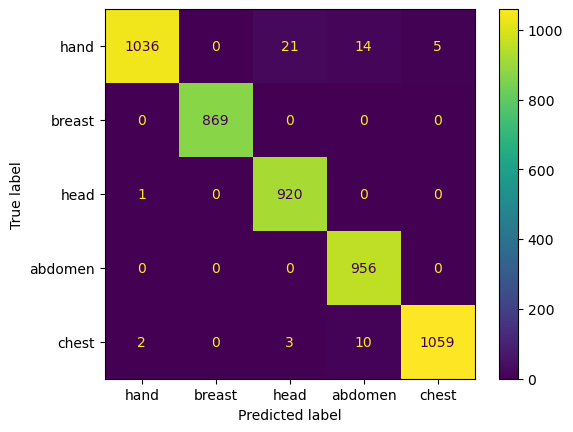

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, ypred_test, display_labels = ['hand', 'breast', 'head', 'abdomen', 'chest'])
plt.show()

As we can see from the classification report and confusion matrix of the test data, **the MLP classifier is doing a great job in classifying the images of each class with more than 98% accuracy, precision, recall and F1 score.**  But there are some hand images predicted as head and abdomen. Otherwise, the algorithm is doing a great job in the classfication process. Now let's look at some of the 50 misclassified images and why it might have happened.

This was our category: ('hand': 0, 'breast': 1, 'head': 2, 'abdomen': 3, 'chest':4]

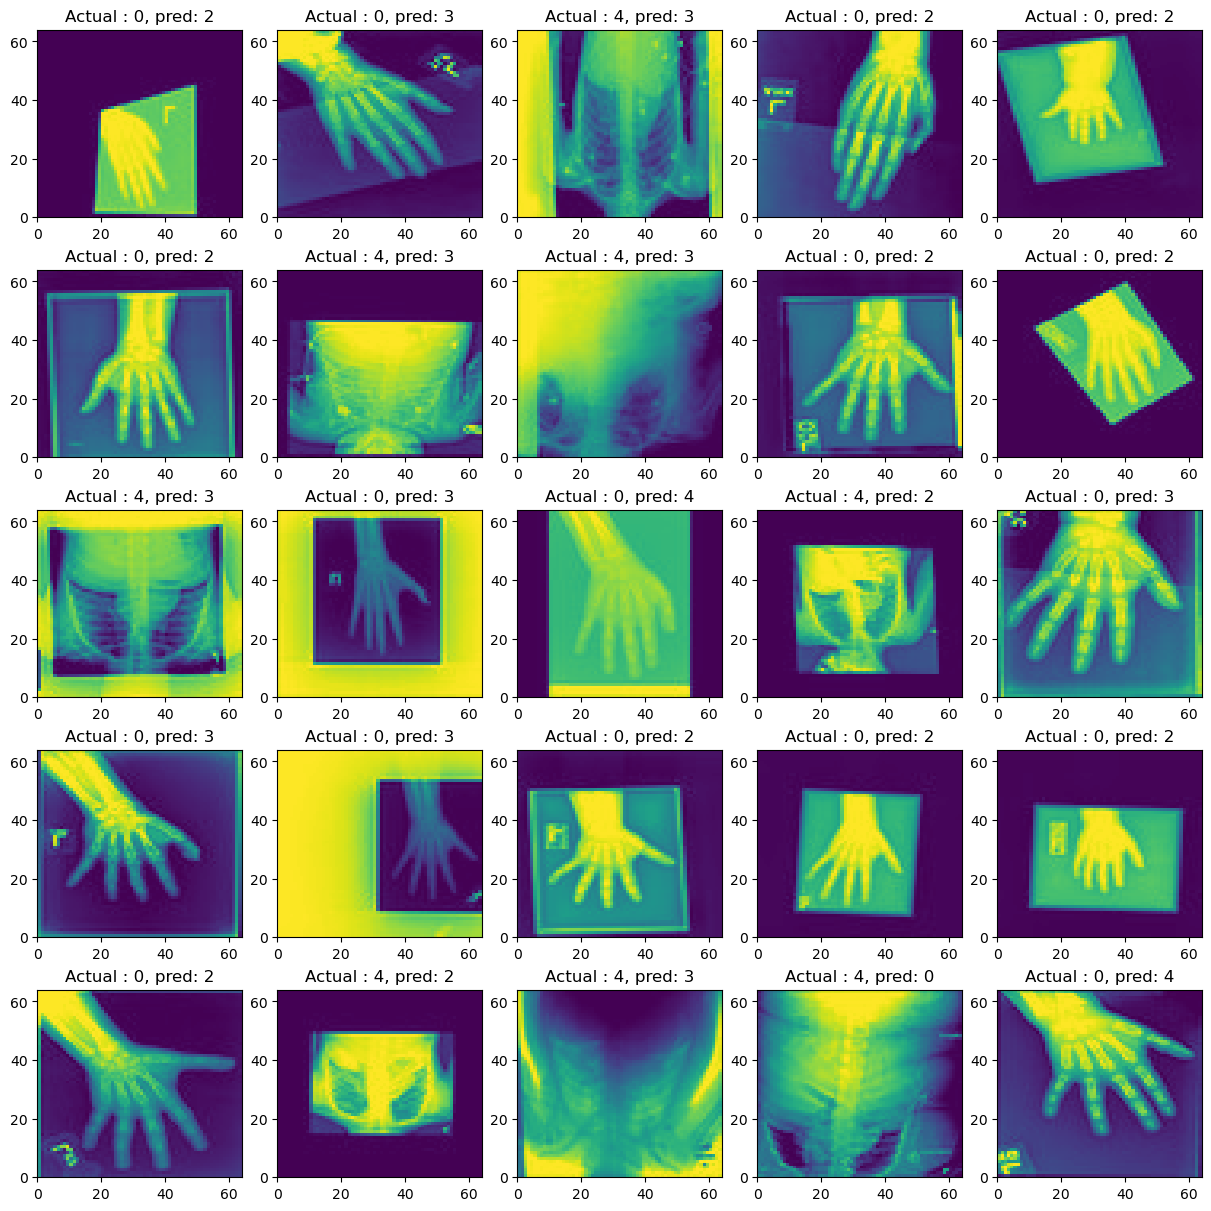

In [23]:
error_ind_test = np.where((y_test[:,0] != ypred_test))[0] # error condidtion


# Plotting the first 25 of the misclassified images:
fig, axs = plt.subplots(5,5, constrained_layout=True, figsize = (12,12))
for i in range(5):
    for j in range(5):
        num = i*5+j
        ind = error_ind_test[num]
        img = X_test[ind,:,:]
        axs[i,j].pcolormesh(img)
        axs[i,j].set_title(f"Actual : {y_test[ind,0]}, pred: {ypred_test[ind]}")
plt.show()

Interestingly, what we can see is that in most of the misclassified cases are from the chest and hand images. Most of these images are zoomed out or zoomed in versions and appears translated in pixel space. The MLP model is finding hard to classify the wonky images which looks different from the normal class of images showed earlier.

Let's build a little more complex model with 3 hidden layers and more units and see if it can detect features from wonky images:

In [24]:
# Building more complex model
model2 = Sequential([
        Flatten(input_shape=[64, 64]), 
        Dense(50, activation="relu", name = 'layer1'),
        Dense(25, activation="relu", name = 'layer2'),
        Dense(15, activation="relu", name = 'layer3'),
        Dense(5, activation="linear", name = 'layer4')
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 layer1 (Dense)              (None, 50)                204850    
                                                                 
 layer2 (Dense)              (None, 25)                1275      
                                                                 
 layer3 (Dense)              (None, 15)                390       
                                                                 
 layer4 (Dense)              (None, 5)                 80        
                                                                 
Total params: 206,595
Trainable params: 206,595
Non-trainable params: 0
_________________________________________________________________


In [25]:

# Compiling and fitting the data
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
               metrics = ["accuracy"])

history2 = model2.fit(X_train, y_train, epochs = 30, validation_data=(X_val, y_val))

Epoch 1/30
1224/1224 [==============================] - 2s 2ms/step - loss: 0.9633 - accuracy: 0.9170 - val_loss: 0.4348 - val_accuracy: 0.9248
Epoch 2/30
1224/1224 [==============================] - 2s 1ms/step - loss: 0.3595 - accuracy: 0.9318 - val_loss: 0.2114 - val_accuracy: 0.9497
Epoch 3/30
1224/1224 [==============================] - 2s 1ms/step - loss: 0.1987 - accuracy: 0.9583 - val_loss: 0.1559 - val_accuracy: 0.9614
Epoch 4/30
1224/1224 [==============================] - 2s 1ms/step - loss: 0.2352 - accuracy: 0.9514 - val_loss: 0.1398 - val_accuracy: 0.9655
Epoch 5/30
1224/1224 [==============================] - 2s 1ms/step - loss: 0.1927 - accuracy: 0.9594 - val_loss: 0.2938 - val_accuracy: 0.9430
Epoch 6/30
1224/1224 [==============================] - 2s 1ms/step - loss: 0.1733 - accuracy: 0.9627 - val_loss: 0.1378 - val_accuracy: 0.9628
Epoch 7/30
1224/1224 [==============================] - 2s 1ms/step - loss: 0.1737 - accuracy: 0.9636 - val_loss: 0.2022 - val_accuracy:

(30, 2)


/var/folders/c8/g5hp4hlx7dv6gv7n9zdg74rc0000gn/T/ipykernel_14087/3758613577.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/var/folders/c8/g5hp4hlx7dv6gv7n9zdg74rc0000gn/T/ipykernel_14087/3758613577.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

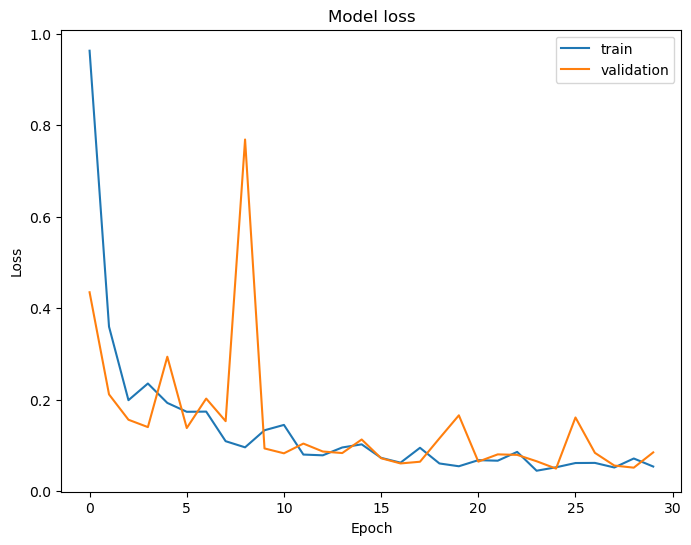

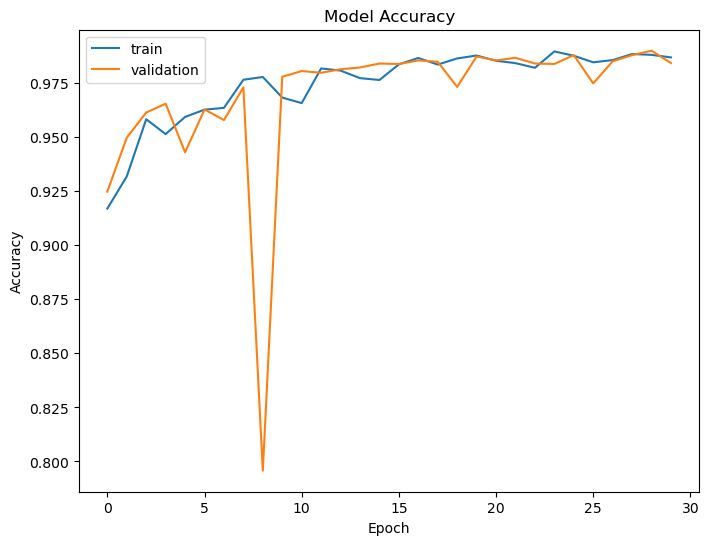

In [26]:
# Now let's plot the model loss and accuracy for both the training and validataion set as a function 
# of number of epochs.

# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history2.history)

# losses data frame
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)

print(df_loss.shape)

# accuracy data frame
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)

# plotting the loss and accuracy
df_loss.plot(title='Model loss',figsize=(8,6)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(8,6)).set(xlabel='Epoch',ylabel='Accuracy')

The loss and accuracy plots looks similiar to the first model. Let's look at the classification report and the confusion matrix for this model.

In [27]:
# plotting the loss and accuracy all in one frame
#pd.DataFrame(history2.history).plot(
#figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch", style=["r--", "b-"])
#plt.show()

In [28]:
# Calculating the predictions for the training dataset
#Get the linear value from the mode
logits_train2 = model2.predict(X_train)
pred_train2 = tf.nn.softmax(logits_train2) # this basically gives the probability of each class
ypred_train2 = np.argmax(pred_train2, axis = 1)
#print(y_pred_train.shape)

#Calculating the predictions for the validation dataset
#Get the linear value from the model
logits_val2 = model2.predict(X_val)
pred_val2 = tf.nn.softmax(logits_val2) # this basically gives the probability of each class
ypred_val2 = np.argmax(pred_val2, axis = 1)

# Calculating the predictions for the test dataset
#Get the linear value from the model
logits_test2 = model2.predict(X_test)
pred_test2 = tf.nn.softmax(logits_test2) # this basically gives the probability of each class
ypred_test2 = np.argmax(pred_test2, axis = 1)

153/153 [==============================] - 0s 505us/step


In [29]:
# Let's look at the classification report
from sklearn.metrics import classification_report

print("Report: Train data")
print(classification_report(y_train, ypred_train2, target_names=['hand', 'breast', 'head', 'abdomen', 'chest']))

print("Report: Validation data")
print(classification_report(y_val, ypred_val2, target_names=['hand', 'breast', 'head', 'abdomen', 'chest']))

print("Report: Test data")
print(classification_report(y_test, ypred_test2, target_names=['hand', 'breast', 'head', 'abdomen', 'chest']))

Report: Train data
              precision    recall  f1-score   support

        hand       0.98      0.98      0.98      7896
      breast       1.00      1.00      1.00      7195
        head       0.99      0.97      0.98      8066
     abdomen       0.97      1.00      0.99      8094
       chest       0.99      0.98      0.99      7912

    accuracy                           0.99     39163
   macro avg       0.99      0.99      0.99     39163
weighted avg       0.99      0.99      0.99     39163

Report: Validation data
              precision    recall  f1-score   support

        hand       0.98      0.98      0.98      1028
      breast       1.00      1.00      1.00       890
        head       0.99      0.96      0.98      1013
     abdomen       0.97      1.00      0.98       950
       chest       0.99      0.98      0.99      1014

    accuracy                           0.98      4895
   macro avg       0.98      0.98      0.98      4895
weighted avg       0.98      0.98 

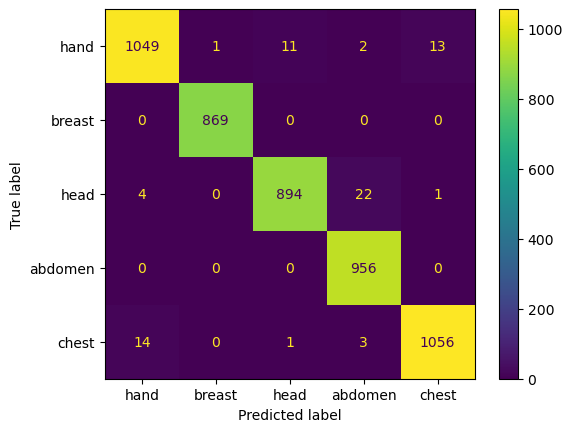

In [30]:
# confusion matrix display
ConfusionMatrixDisplay.from_predictions(y_test, ypred_test2, display_labels = ['hand', 'breast', 'head', 'abdomen', 'chest'])
plt.show()

 The precision, recall and F1 score of the second model looks more or less similiar to the first model due to rounding upto 2 digits. But as you can see, there are 50 misclassified samples from the first model and 28 misclassified ones in from the second model. So definitely the second model is doing a better job in the classification problem. Let's take a look at all the misclassifed ones again.

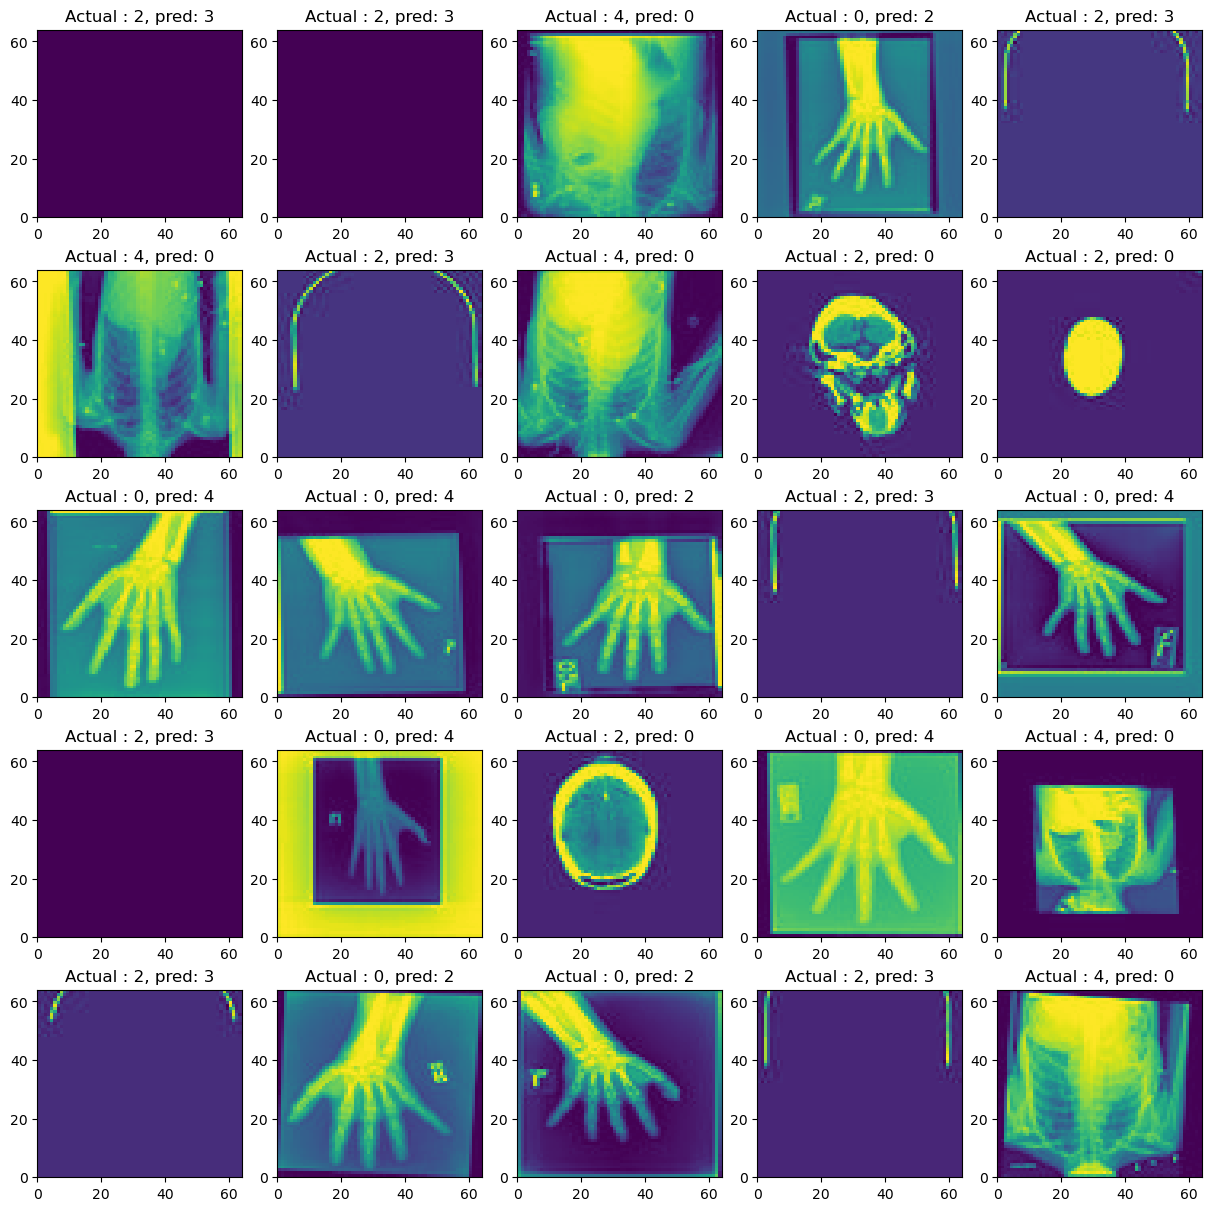

In [31]:
error_ind_test2 = np.where((y_test[:,0] != ypred_test2))[0] # error condidtion

# Plotting the first 25 of the misclassified images:
fig, axs = plt.subplots(5,5, constrained_layout=True, figsize = (12,12))
for i in range(5):
    for j in range(5):
        num = i*5+j
        ind = error_ind_test2[num]
        img = X_test[ind,:,:]
        axs[i,j].pcolormesh(img)
        axs[i,j].set_title(f"Actual : {y_test[ind,0]}, pred: {ypred_test2[ind]}")
plt.show()

Both the models are finding it difficult to classify the pictures of hands coming in from different directions or stretched or rotated versions.

### Convolutional Neural Networks (CNNs)
This dataset is a really good dataset and both the MLP models are doing a great job in the classification. However, a DNN model does not work well if the images are stretched, squeezed or rotatedd. Let's build a simple CNN model to see if we can classify these hands with better accuracy. CNN is the widely used techique in computer vision purposes which can build deep learning models efficiently with lesser number of shared parameters and it can identify different features with translational invariance.

Let's build the CNN model now.

In [32]:
# Let's change the shape of the data array for inputing to CNN
# the current array does not have a frequency axis. Let's add a new frequency axis to all the datasets
X_train_new = np.expand_dims(X_train, axis=3)
X_val_new = np.expand_dims(X_val, axis=3)
X_test_new = np.expand_dims(X_test, axis=3)

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Input

input_shape = X_train_new.shape[1:]
print(input_shape)

# Let's build a CNN model of this form
# Input >> ConV2D << Maxpool << Conv2D <<  Maxpool <<  ConV2D << Maxpool << Conv2D << Maxpool << Flatten << Dense << Dense << Dense << Dense (softmax)
cnn = Sequential([
    Input(shape=input_shape),
    Conv2D(filters=32, kernel_size=3, strides=(1,1), activation='relu', padding='valid', name = 'conv1'), 
    MaxPool2D(pool_size=(2, 2), strides=(2,2), name = 'pool1'),
    Conv2D(filters=64, kernel_size=3, strides=(1,1), activation='relu', padding='valid', name = 'conv2'), 
    MaxPool2D(pool_size=(2, 2), strides=(2,2), name = 'pool2'),
    Conv2D(filters=128, kernel_size=3, strides=(1,1), activation='relu', padding='valid', name = 'conv3'),
    MaxPool2D(pool_size=(2, 2), strides=(2,2), name = 'pool3'),
    Conv2D(filters=256, kernel_size=3, strides=(1,1), activation='relu', padding='valid', name = 'conv4'),          
    MaxPool2D(pool_size=(2, 2), strides=(1,1), name = 'pool4'),
    Flatten(name = 'Flat'),
    Dense(512, activation='relu', name='Dense1'),
    Dense(128, activation='relu', name='Dense2'),
    Dense(32, activation='relu', name='Dense3'),
    Dense(5, activation='softmax', name='output' )])

cnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
cnn.summary()

(64, 64, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 62, 62, 32)        320       
                                                                 
 pool1 (MaxPooling2D)        (None, 31, 31, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 29, 29, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 14, 14, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 12, 12, 128)       73856     
                                                                 
 pool3 (MaxPooling2D)        (None, 6, 6, 128)         0         
                                                                 
 conv4 (Conv2D)              (None, 4, 4, 

This model has lesser number of parameters compared to the second DNN model. Now let's fit the model with the data.

In [34]:
history3 = cnn.fit(X_train_new, y_train, batch_size=64, epochs=10, validation_data=(X_val_new, y_val))

Epoch 1/10
612/612 [==============================] - 50s 81ms/step - loss: 0.2179 - accuracy: 0.9690 - val_loss: 0.0206 - val_accuracy: 0.9939
Epoch 2/10
612/612 [==============================] - 48s 79ms/step - loss: 0.0227 - accuracy: 0.9936 - val_loss: 0.0260 - val_accuracy: 0.9939
Epoch 3/10
612/612 [==============================] - 48s 79ms/step - loss: 0.0115 - accuracy: 0.9972 - val_loss: 0.0233 - val_accuracy: 0.9941
Epoch 4/10
612/612 [==============================] - 49s 79ms/step - loss: 0.0049 - accuracy: 0.9988 - val_loss: 0.0031 - val_accuracy: 0.9988
Epoch 5/10
612/612 [==============================] - 48s 78ms/step - loss: 0.0213 - accuracy: 0.9954 - val_loss: 0.0169 - val_accuracy: 0.9959
Epoch 6/10
612/612 [==============================] - 47s 77ms/step - loss: 0.0071 - accuracy: 0.9982 - val_loss: 0.0031 - val_accuracy: 0.9992
Epoch 7/10
612/612 [==============================] - 48s 78ms/step - loss: 0.0172 - accuracy: 0.9970 - val_loss: 0.0925 - val_accuracy:

(10, 2)


/var/folders/c8/g5hp4hlx7dv6gv7n9zdg74rc0000gn/T/ipykernel_14087/2268470446.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/var/folders/c8/g5hp4hlx7dv6gv7n9zdg74rc0000gn/T/ipykernel_14087/2268470446.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

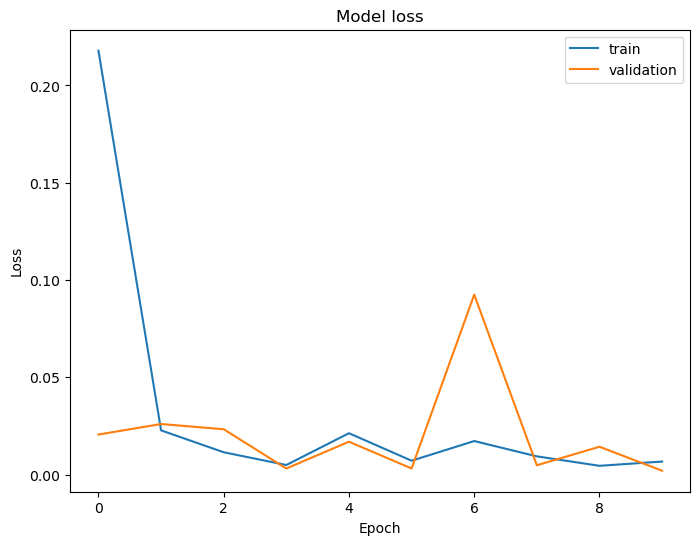

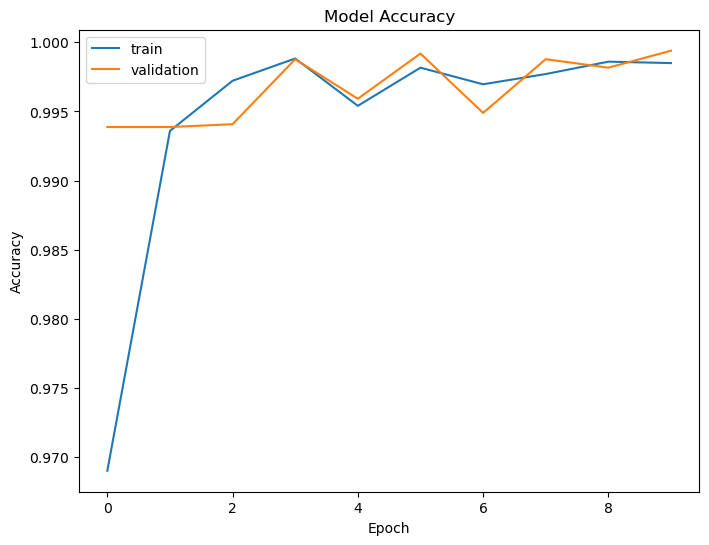

In [35]:
# Now let's plot the model loss and accuracy for both the training and validataion set as a function 
# of number of epochs.

# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history3.history)

# losses data frame
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)

print(df_loss.shape)

# accuracy data frame
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)

# plotting the loss and accuracy
df_loss.plot(title='Model loss',figsize=(8,6)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(8,6)).set(xlabel='Epoch',ylabel='Accuracy')

In [36]:
# Now calcualte the predictions
ypred_train3 = np.argmax(cnn.predict(X_train_new), axis=1)
ypred_val3 = np.argmax(cnn.predict(X_val_new), axis=1)
ypred_test3 = np.argmax(cnn.predict(X_test_new), axis=1)

153/153 [==============================] - 2s 14ms/step


In [37]:
# Let's look at the classification report
from sklearn.metrics import classification_report

print("Report: Train data")
print(classification_report(y_train, ypred_train3, target_names=['hand', 'breast', 'head', 'abdomen', 'chest']))

print("Report: Validation data")
print(classification_report(y_val, ypred_val3, target_names=['hand', 'breast', 'head', 'abdomen', 'chest']))

print("Report: Test data")
print(classification_report(y_test, ypred_test3, target_names=['hand', 'breast', 'head', 'abdomen', 'chest']))

Report: Train data
              precision    recall  f1-score   support

        hand       1.00      1.00      1.00      7896
      breast       1.00      1.00      1.00      7195
        head       1.00      1.00      1.00      8066
     abdomen       1.00      1.00      1.00      8094
       chest       1.00      1.00      1.00      7912

    accuracy                           1.00     39163
   macro avg       1.00      1.00      1.00     39163
weighted avg       1.00      1.00      1.00     39163

Report: Validation data
              precision    recall  f1-score   support

        hand       1.00      1.00      1.00      1028
      breast       1.00      1.00      1.00       890
        head       1.00      1.00      1.00      1013
     abdomen       1.00      1.00      1.00       950
       chest       1.00      1.00      1.00      1014

    accuracy                           1.00      4895
   macro avg       1.00      1.00      1.00      4895
weighted avg       1.00      1.00 

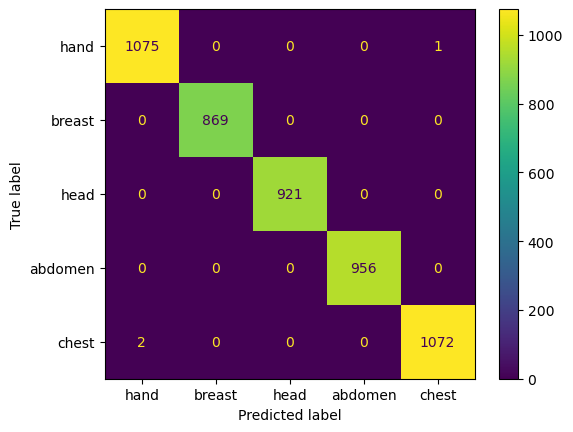

In [38]:
# confusion matrix display
ConfusionMatrixDisplay.from_predictions(y_test, ypred_test3, display_labels = ['hand', 'breast', 'head', 'abdomen', 'chest'])
plt.show()

The classification metrics of CNN are far better than the DNN models. All the metric scores are clost to 100%. If we look at the confusion matrix, the misclassification of the hand and the chest images have gone down and there are only 3 misclassified samples. Let's take a look at the misclassified examples.

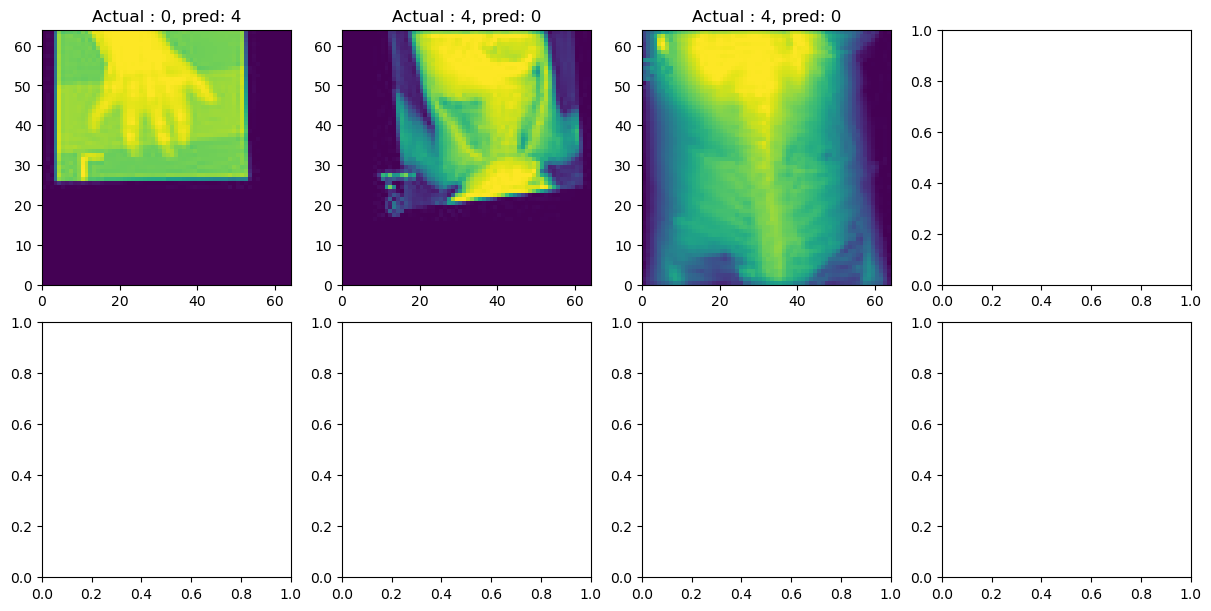

In [44]:
error_ind_test3 = np.where((y_test[:,0] != ypred_test3))[0] # error condidtion
len_ind = len(error_ind_test3)

# Plotting the first 25 of the misclassified images:
fig, axs = plt.subplots(2,4, constrained_layout=True, figsize = (12,6))
for i in range(2):
    for j in range(4):
        num = i*4+j
        if num < len_ind:
            ind = error_ind_test3[num]
            img = X_test[ind,:,:]
            axs[i,j].pcolormesh(img)
            axs[i,j].set_title(f"Actual : {y_test[ind,0]}, pred: {ypred_test3[ind]}")
plt.show()

The number of misclassified images of hands and chest has gone down. Overall the CNN does an exeptional job in the classification. With regards to the hand and chest images that are misclassified, an image augmentation of existing outlier images and training again might help to identify them. Since these numbers are very low, we are not going to do any image augmentation now.

### Conclusion
For this medical image classification purpose, we utilized a curated and balanced medical MNIST dataset. Both the dense neural networks and CNNs are model are doing great job in classifying images with more than 99 % accuracy, precision, recall and F1-scores. Among these models, CNN clearly has an upperhand in getting the best performance out the classification and it makes sense as it is a widely utilized algorithm for computer vision purposes.